# Imports

In [75]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib import keras
from sklearn import datasets
from sklearn import linear_model
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Simple Mock Data

Lets create a simple mock dataset with one independent variable and one dependent variable with a little noise. 

In [83]:
Nsamp = 50
Nfeatures = 1
xarr = np.linspace(-0.5, 0.5, Nsamp)
np.random.seed(83749)
beta_0 = -2.0
beta_1 = 4.3
yarr = (beta_0 + beta_1 * xarr) + (np.random.normal(size=Nsamp) * 0.5)

mdl = linear_model.LinearRegression(fit_intercept=False)
mdl = mdl.fit(np.c_[np.ones(Nsamp), xarr], yarr)
mdl.coef_

array([-2.0517912 ,  4.08511933])

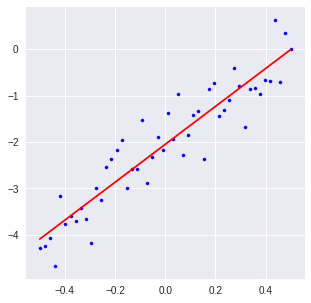

In [84]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(xarr, yarr, s=10, color='blue')
plt.plot(xarr, mdl.coef_[0] + mdl.coef_[1] * xarr, color='red')

In [105]:
ph_x = tf.placeholder(tf.float32, [None, Nfeatures], name='features')
ph_y = tf.placeholder(tf.float32, [None, 1], name='output')
ph_x, ph_y

# Set model weights
v_W = tf.Variable(tf.random_normal([Nfeatures, 1]), name='weights')
v_b = tf.Variable(tf.zeros([1]), name='bias')
v_z = tf.matmul(ph_x, v_W) + v_b
cost_1 = tf.squared_difference(v_z, ph_y)
cost_2 = tf.reduce_mean(cost_1)

learning_rate=0.1
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_2)
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
#with tf.name_scope('Model'):
#    # Model
#    pred = tf.matmul(x, W) + b # basic linear regression
#with tf.name_scope('Loss'):
#    # Minimize error (mean squared error)
#    cost = tf.reduce_mean(-tf.reduce_sum(y - pred)*tf.log(pred), reduction_indices=1))
#with tf.name_scope('SGD'):
#    # Gradient Descent
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
#with tf.name_scope('Accuracy'):
#    # Accuracy
#    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#    acc = tf.reduce_mean(tf.cast(acc, tf.float32))



In [106]:
init = tf.global_variables_initializer()

merged = tf.summary.merge_all()



# Launch the graph
feed_dict = {ph_x: xarr.reshape(Nsamp, 1), ph_y: yarr.reshape(Nsamp,1)}
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('tmp/tensorflow/logs', sess.graph)
    
    sess.run(init)
    z_out = sess.run(v_z, feed_dict=feed_dict)
    cost_1_out = sess.run(cost_1, feed_dict=feed_dict)
    cost_2_out = sess.run(cost_2, feed_dict=feed_dict)
    for i in range(300):
        train_step_out = sess.run(train_step, feed_dict=feed_dict)
    W_out = sess.run(v_W, feed_dict=feed_dict)
    b_out = sess.run(v_b, feed_dict=feed_dict)

print(W_out)
print(b_out)


[[ 4.07353592]]
[-2.05179071]


# Boston Housing Dataset

  - ## `feautres`: raw features variables in DataFrame 
  - ## `target`: raw target variable in DataFrame

In [2]:
boston = datasets.load_boston()
print(boston['DESCR'])
features = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
target = pd.DataFrame(data=boston['target'], columns=['MEDV'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
features.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
target.head(5)

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


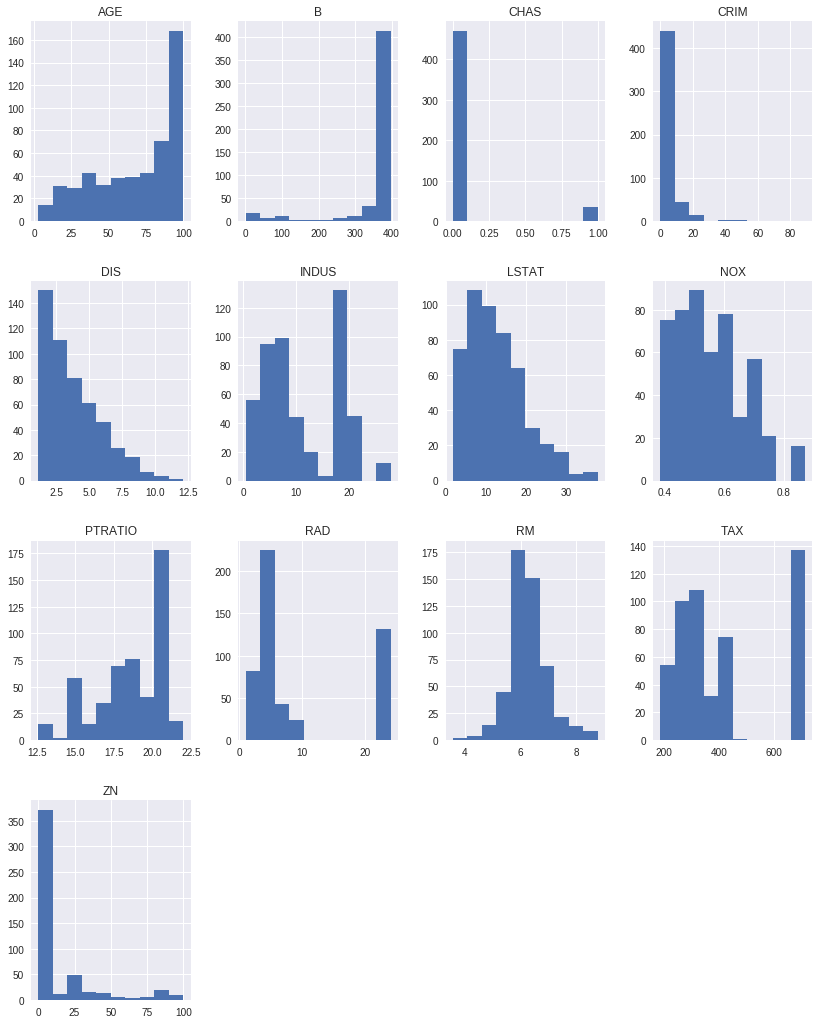

In [5]:
hh = features.hist(figsize=(14,18))

# Center and Normalize

In [6]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
scalerX.fit(features)
dfXn = pd.DataFrame(data=scalerX.transform(features), columns=features.columns)
scalerY = StandardScaler()
scalerY.fit(target)
dfYn = pd.DataFrame(data=scalerY.transform(target), columns=target.columns)

In [7]:
dfXn.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


In [8]:
dfYn.head(5)

,MEDV
0,0.159686
1,-0.101524
2,1.324247
3,1.182758
4,1.487503


# Statsmodels Linear Regression

In [9]:
dfXn1 = dfXn.copy()
dfXn1.insert(loc=0, column='intercept', value=1)
results = sm.OLS(dfYn, dfXn1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 30 Jun 2017   Prob (F-statistic):          6.95e-135
Time:                        17:40:41   Log-Likelihood:                -376.58
No. Observations:                 506   AIC:                             781.2
Df Residuals:                     492   BIC:                             840.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.345e-16      0.023   1.89e-14      1.0

In [10]:
dfYn.max()
target.max()

MEDV    50.0
dtype: float64

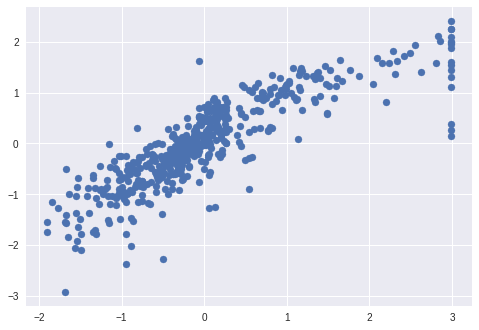

In [11]:
plt.scatter(dfYn.values, results.fittedvalues.values)

In [12]:
from sklearn import linear_model
mdl = linear_model.LinearRegression(fit_intercept=False)
mdl = mdl.fit(dfXn1.values, dfYn.values)

In [13]:
print('n_params (statsmodels): ', len(results.params))
print('n params (sklearn linear): ', len(mdl.coef_.flatten()))

n_params (statsmodels):  14
n params (sklearn linear):  14


In [14]:
print(results.params)
print()
print(mdl.coef_)

intercept    4.345482e-16
CRIM        -1.001752e-01
ZN           1.176512e-01
INDUS        1.556018e-02
CHAS         7.424930e-02
NOX         -2.242153e-01
RM           2.906659e-01
AGE          2.298716e-03
DIS         -3.378803e-01
RAD          2.893756e-01
TAX         -2.259355e-01
PTRATIO     -2.244398e-01
B            9.323458e-02
LSTAT       -4.079969e-01
dtype: float64

[[  4.84321575e-16  -1.00175225e-01   1.17651199e-01   1.55601811e-02
    7.42493038e-02  -2.24215267e-01   2.90665875e-01   2.29871616e-03
   -3.37880295e-01   2.89375620e-01  -2.25935517e-01  -2.24439849e-01
    9.32345842e-02  -4.07996856e-01]]


In [15]:
np.all(np.abs(mdl.coef_ - results.params.values) < 1.0e-10)

True

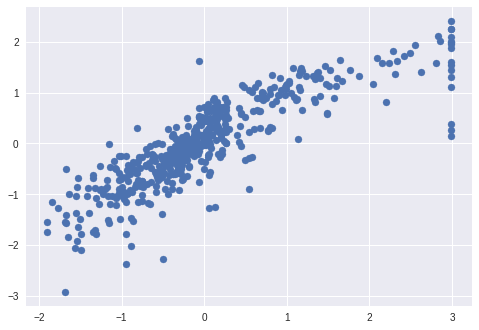

In [16]:
plt.scatter(dfYn.values, mdl.predict(dfXn1.values).flatten())

# Linear Regression, Keras

In [17]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.optimizers import SGD, Adam, RMSprop
from keras.losses import mean_squared_error

Using TensorFlow backend.


In [21]:
nfeatures = features.shape[1]
model = Sequential()
model.add(InputLayer(input_shape=(nfeatures,), name='input'))
model.add(Dense(1, kernel_initializer='uniform', activation='linear', name='dense_1'))
model.summary()
weights_initial = model.get_weights()

print('weights_initial - input nodes: \n', weights_initial[0])
print('weights_initial - bias node: ', weights_initial[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
weights_initial - input nodes: 
 [[ 0.01596148]
 [-0.01603906]
 [ 0.00769339]
 [-0.019129  ]
 [-0.02154226]
 [-0.0025918 ]
 [-0.03326609]
 [-0.03417128]
 [ 0.03996314]
 [ 0.03899397]
 [-0.03798314]
 [ 0.02269669]
 [-0.01864571]]
weights_initial - bias node:  [ 0.]


In [22]:
model.compile(optimizer=RMSprop(lr=0.001), loss='mean_squared_error')

In [23]:
dfYn.shape

(506, 1)

In [24]:
model.set_weights(weights_initial)
history = model.fit(dfXn.values, dfYn.values, epochs=5000, batch_size=dfYn.shape[0], verbose=0)

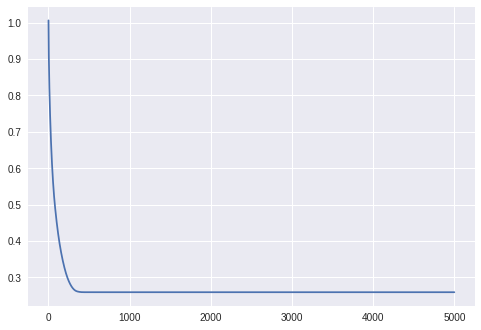

In [25]:
plt.plot(history.history['loss'])

In [26]:
model.get_weights()

[array([[-0.10067523],
        [ 0.1181512 ],
        [ 0.01506018],
        [ 0.07374932],
        [-0.22471525],
        [ 0.29116589],
        [ 0.00179871],
        [-0.33738026],
        [ 0.28887564],
        [-0.22643556],
        [-0.22493985],
        [ 0.09373459],
        [-0.40849686]], dtype=float32), array([ 0.00049998], dtype=float32)]

In [27]:
mdl.coef_

array([[  4.84321575e-16,  -1.00175225e-01,   1.17651199e-01,
          1.55601811e-02,   7.42493038e-02,  -2.24215267e-01,
          2.90665875e-01,   2.29871616e-03,  -3.37880295e-01,
          2.89375620e-01,  -2.25935517e-01,  -2.24439849e-01,
          9.32345842e-02,  -4.07996856e-01]])

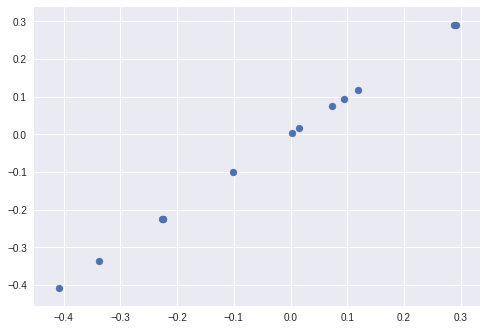

In [28]:
plt.scatter(model.get_weights()[0].flatten(), mdl.coef_.flatten()[1:])

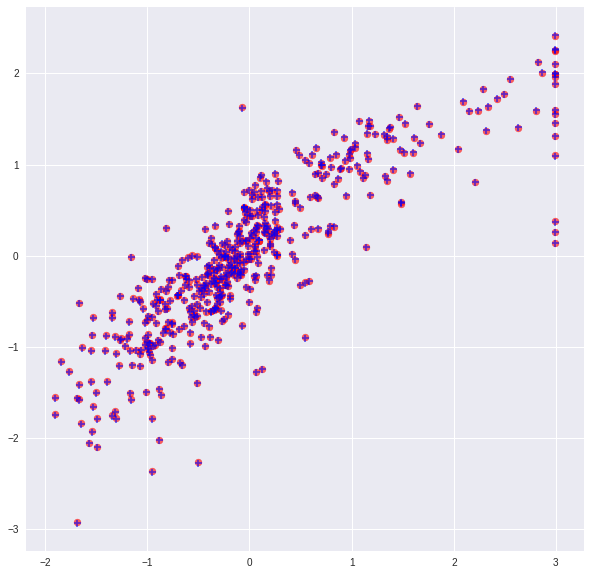

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(dfYn.values, mdl.predict(dfXn1.values).flatten(), color='red', alpha=0.6, marker='o')
plt.scatter(dfYn.values, model.predict(dfXn.values), color='blue', alpha=0.6, marker='+')

In [30]:
# tf Graph Input

# input data 
n_samples, n_features = features.shape
x = tf.placeholder(tf.float32, [None, n_features], name='InputData')
# output data 
y = tf.placeholder(tf.float32, [None, 1], name='TargetData')

# Set model weights
W = tf.Variable(tf.random_normal([n_features, 1]), name='Weights')
b = tf.Variable(tf.zeros([1]), name='Bias')
z = tf.matmul(x,W) + b
cost_1 = tf.squared_difference(z,y)
cost_2 = tf.reduce_mean(cost_1)

learning_rate=0.1
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_2)
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
#with tf.name_scope('Model'):
#    # Model
#    pred = tf.matmul(x, W) + b # basic linear regression
#with tf.name_scope('Loss'):
#    # Minimize error (mean squared error)
#    cost = tf.reduce_mean(-tf.reduce_sum(y - pred)*tf.log(pred), reduction_indices=1))
#with tf.name_scope('SGD'):
#    # Gradient Descent
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
#with tf.name_scope('Accuracy'):
#    # Accuracy
#    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#    acc = tf.reduce_mean(tf.cast(acc, tf.float32))




In [31]:
tf.Session().run(y, feed_dict={x: features.values, y: target.values}).shape

(506, 1)

In [32]:
init = tf.global_variables_initializer()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    z_out = sess.run(z, feed_dict={x: features.values, y:target.values})
    cost_1_out = sess.run(cost_1, feed_dict={x: features.values, y:target.values})
    cost_2_out = sess.run(cost_2, feed_dict={x: features.values, y:target.values})
    for i in range(100):
        train_step_out = sess.run(train_step, feed_dict={x: features.values, y:target.values})
print(cost_1_out[0:5,:])
print(cost_2_out)
print(train_step_out)

[[ 1259.02819824]
 [ 5381.42431641]
 [ 2395.48339844]
 [ 2227.1081543 ]
 [ 2374.77709961]]
3882.06
None


In [33]:
sess = tf.Session()

In [34]:
sess.run(c)

NameError: name 'c' is not defined

In [35]:
x

<tf.Tensor 'InputData_1:0' shape=(?, 13) dtype=float32>

In [36]:
y

<tf.Tensor 'LabelData_1:0' shape=(?, 1) dtype=float32>

In [38]:
W

<tf.Variable 'Weights:0' shape=(13, 1) dtype=float32_ref>

In [39]:
b

<tf.Variable 'Bias:0' shape=(1,) dtype=float32_ref>